In [1]:
import pandas as pd
import numpy as np
import tensorflow 
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import datetime
import re
import string

import transformers
from transformers import AutoModel, BertTokenizerFast

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

%matplotlib inline

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
train = train.fillna("")
train['new_text'] = train['keyword'] + " " + train['location'] + " " + train['text']

test = test.fillna("")
test['new_text'] = test['keyword'] + " " + test['location'] + " " + test['text']

In [6]:
print("Size of train dataset: " + str(train.shape))
print("Size of test dataset: " + str(test.shape))

Size of train dataset: (7613, 6)
Size of test dataset: (3263, 5)


### Use GPU if its available

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    
    print("There are %d GPU(s) available" % torch.cuda.device_count())
    print("We will use the GPU:", torch.cuda.get_device_name(0))
else:
    print("No GPU Available, using CPU instead")

There are 1 GPU(s) available
We will use the GPU: NVIDIA GeForce RTX 3070 Ti


### Loop to remove noise from tweets

In [8]:
def remove_noise(df):
    df = df.copy()
    new_tweets = []
    for text in df['new_text']:
        # it will remove the old style retweet text "RT"
        new_text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)

        # it will remove hyperlinks
        new_text = re.sub(r'https?:\/\/.*[\r\n]*', '', new_text)

        # it will remove hashtags. We have to be careful here not to remove 
        # the whole hashtag because text of hashtags contains huge information. 
        # only removing the hash # sign from the word
        # tweet2 = re.sub(r'#', '', tweet2)
        new_text = ''.join([c for c in new_text if ord(c) < 128])

        # it will remove single numeric terms in the tweet. 
#         new_text = re.sub(r'[0-9]', '', new_text) # does temporal information matter to bert? lets test it out
#         print('\nAfter removing old style tweet, hyperlinks and # sign')
        new_tweets.append(new_text)
    
    df['new_text'] = new_tweets
    return df

In [9]:
new_train = train.copy()
new_train = remove_noise(new_train)

In [10]:
new_train[new_train['id'] == 404]['new_text'].values[0]

"apocalypse Elk Grove, CA, USA Another hour! It's August 05 2015 at 08:02PM Here's Red Rover Zombie Apocalypse 2014!  #internetradio #collegeradi_"

In [11]:
train[train['id'] == 404]['new_text'].values[0]

"apocalypse Elk Grove, CA, USA Another hour! It's August 05 2015 at 08:02PM Here's Red Rover Zombie Apocalypse 2014! http://t.co/cf9e6TU3g7 #internetradio #collegeradi\x89Û_"

In [12]:
# tweet = train[train['id'] == 219]['text'].values[0]
# tweet

In [13]:
# # it will remove the old style retweet text "RT"
# tweet2 = re.sub(r'^RT[\s]+', '', tweet)

# # it will remove hyperlinks
# tweet2 = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet2)

# # it will remove hashtags. We have to be careful here not to remove 
# # the whole hashtag because text of hashtags contains huge information. 
# # only removing the hash # sign from the word
# # tweet2 = re.sub(r'#', '', tweet2)
# tweet2 = ''.join([c for c in tweet2 if ord(c) < 128])

# # it will remove single numeric terms in the tweet. 
# tweet2 = re.sub(r'[0-9]', '', tweet2) # does temporal information matter to bert? lets test it out
# print('\nAfter removing old style tweet, hyperlinks and # sign')
# tweet2

### Split train dataset into train, validation and test sets

In [14]:
train_text, temp_text, train_labels, temp_labels = train_test_split(train['new_text'], 
                                                                    train['target'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=train['target'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

### Initialize tokenizer and finding the average length of tokens for train and test sets

In [15]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<AxesSubplot:>

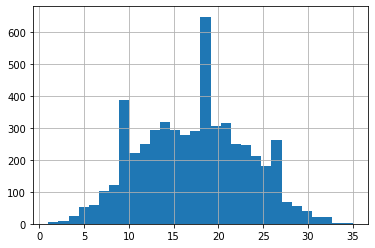

In [16]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [17]:
max_seq_len = 35

In [18]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

C:\Users\Doubl\Desktop\Projects\nlp\disaster_tweets\lib\site-packages\transformers\tokenization_utils_base.py:2226: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [19]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# type(tokens_train['attention_mask'][0][0])

In [20]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 16

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [21]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [22]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):

        super(BERT_Arch, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict = False)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)

        return x

In [23]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [24]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [25]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight = 'balanced', 
                                 classes = np.unique(train_labels), 
                                 y = train_labels)

print(class_wts)

[0.87676867 1.16353712]


In [26]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 15

In [27]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [28]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds = elapsed_rounded))

In [29]:
def train():
  
    model.train()

    total_loss, total_accuracy = 0, 0
    train_accuracy, nb_train_steps = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch
#         print(type(sent_id))
#         print(type(mask))
#         print(type(labels))

        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)
        
        logits = preds
        logits = logits.detach().cpu().numpy()
        
        label_ids = labels.to('cpu').numpy()
        tmp_train_accuracy = flat_accuracy(logits, label_ids)
        train_accuracy += tmp_train_accuracy

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)
        
        nb_train_steps += 1

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)
    
    accuracy = train_accuracy / nb_train_steps
    
    print("")
    print("Training Accuracy: {0:.5f}".format(accuracy))

    #returns the loss and predictions
    return avg_loss, accuracy, total_preds


In [30]:
def evaluate():
  
    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()
    
    eval_accuracy, nb_eval_steps = 0, 0
    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

            # Calculate elapsed time in minutes.
#             elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)
            
            logits = preds
            logits = logits.detach().cpu().numpy()

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)
            
        label_ids = labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        
        nb_eval_steps += 1
    
    print("")
    accuracy = eval_accuracy / nb_eval_steps
    print("Validation Accuracy: {0:.5f}".format(accuracy))
    
    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, accuracy, total_preds

In [31]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_acc = []
val_acc = []
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, train_accuracy, _ = train()
    
    #evaluate model
    valid_loss, val_accuracy, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_acc.append(train_accuracy)
    val_acc.append(val_accuracy)
    
    print(f'Training Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 15
  Batch    50  of    334.
  Batch   100  of    334.
  Batch   150  of    334.
  Batch   200  of    334.
  Batch   250  of    334.
  Batch   300  of    334.

Training Accuracy: 0.64671

Evaluating...
  Batch    50  of     72.

Validation Accuracy: 0.73206
Training Loss: 0.636
Validation Loss: 0.558

 Epoch 2 / 15
  Batch    50  of    334.
  Batch   100  of    334.
  Batch   150  of    334.
  Batch   200  of    334.
  Batch   250  of    334.
  Batch   300  of    334.

Training Accuracy: 0.68189

Evaluating...
  Batch    50  of     72.

Validation Accuracy: 0.73727
Training Loss: 0.603
Validation Loss: 0.542

 Epoch 3 / 15
  Batch    50  of    334.
  Batch   100  of    334.
  Batch   150  of    334.
  Batch   200  of    334.
  Batch   250  of    334.
  Batch   300  of    334.

Training Accuracy: 0.69461

Evaluating...
  Batch    50  of     72.

Validation Accuracy: 0.75984
Training Loss: 0.588
Validation Loss: 0.543

 Epoch 4 / 15
  Batch    50  of    334.
  Batch   100  of

In [59]:
r_dict = {
    "train_accuracy": train_acc,
    "train_loss": train_losses,
    "val_accuracy": val_acc,
    "val_loss": valid_losses,
}

In [60]:
results = pd.DataFrame(r_dict)
results

,train_accuracy,train_loss,val_accuracy,val_loss
0,0.646707,0.635526,0.732060,0.558236
1,0.681886,0.602934,0.737269,0.542150
2,0.694611,0.587704,0.759838,0.542607
3,0.714446,0.580848,0.750289,0.520255
4,0.720060,0.560827,0.677662,0.565010
5,0.729229,0.553256,0.734086,0.523347
6,0.731287,0.547326,0.768808,0.516024
7,0.725861,0.555922,0.754051,0.556682
8,0.738211,0.541520,0.725405,0.536845
9,0.738024,0.538642,0.698495,0.561817


In [61]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [62]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       652
           1       0.76      0.73      0.74       490

    accuracy                           0.78      1142
   macro avg       0.78      0.78      0.78      1142
weighted avg       0.78      0.78      0.78      1142



In [63]:
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,537,115
1,133,357


In [35]:
# from transformers import BertTokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

In [36]:
# train_inputs = []
# test_inputs = []
# train_length = []
# test_length = []

# # for sentence in train['text']:
# for sentence in new_train['new_text']:
#     encoded_sentence = tokenizer.encode(sentence, add_special_tokens = True)
#     train_inputs.append(encoded_sentence)
#     train_length.append(len(encoded_sentence))

# for sentence in test['new_text']:
#     encoded_sentence = tokenizer.encode(sentence, add_special_tokens = True)
#     test_inputs.append(encoded_sentence)
#     test_length.append(len(encoded_sentence))

# print("Train")
# print("Min Length:", min(train_length))
# print("Median Length:", np.median(train_length))
# print("Max Length:", max(train_length))
# print("")

# print("Test")
# print("Min Length:", min(test_length))
# print("Median Length:", np.median(test_length))
# print("Max Length:", max(test_length))

In [37]:
# sns.distplot(train_length)

In [38]:
# sns.distplot(test_length)

In [39]:
# MAX_LEN = 90

### Distribution of disaster to non-disaster tweets

In [40]:
# labels = new_train['target']
# print("Number of disaster tweets: " + str(len(train[train['target'] == 1]['target'])))
# print("Number of non-disaster tweets: " + str(len(train[train['target'] == 0]['target'])))
# print("Percentage of disaster to non-disaster tweets: " + str(round(len(train[train['target'] == 1]['target']) / len(train['target']), 2)))

In [41]:
# X = new_train.drop(columns = ['target'])
# y = new_train['target']
# SEED = 2022

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = SEED)

In [42]:
# print("Shape of training data:", str(X_train.shape))
# print("Shape of validation data:", str(X_val.shape))

### Preprocess the data into input_ids and attention masks 

In [43]:
# from keras.preprocessing.sequence import pad_sequences

# def process_data(df, max_length):
#     input_ids = []
#     attention_masks = []
    
#     for sentence in df['new_text']:
#         encoded_sentence = tokenizer.encode(sentence, add_special_tokens = True)
#         input_ids.append(encoded_sentence)
        
#     input_ids = pad_sequences(input_ids, maxlen = max_length, dtype = 'long', value = 0, 
#                              truncating = 'post', padding = 'post')
    
#     for sentence in input_ids:
#         attention_masks.append([1 if id > 0 else 0 for id in sentence])
                                
#     return input_ids, np.array(attention_masks, dtype = np.int64)

In [44]:
# train_inputs, train_attn_masks = process_data(X_train, MAX_LEN)
# val_inputs, val_attn_masks = process_data(X_val, MAX_LEN)
# test_inputs, test_attn_masks = process_data(test, MAX_LEN)

In [45]:
# print("Train input size: ", str(train_inputs.shape))
# print("Validation input size: ", str(val_inputs.shape))
# print("Test input size: ", str(test_inputs.shape))

### Convert to numpy int64, then into pytorch tensors

In [46]:
# train_inputs = train_inputs.astype(np.int64)
# val_inputs = val_inputs.astype(np.int64)
# test_inputs = test_inputs.astype(np.int64)

# train_labels = np.array(y_train, dtype = np.int64)
# val_labels = np.array(y_val, dtype = np.int64)

In [47]:
# train_inputs = torch.tensor(train_inputs)
# train_labels = torch.tensor(train_labels)
# train_masks = torch.tensor(train_attn_masks)

# val_inputs = torch.tensor(val_inputs)
# val_labels = torch.tensor(val_labels)
# val_masks = torch.tensor(val_attn_masks)

# test_inputs = torch.tensor(test_inputs)
# test_masks = torch.tensor(test_attn_masks)

### Batch the data into DataLoaders

In [48]:
# from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# batch_size = 16

# train_data = TensorDataset(train_inputs, train_masks, train_labels)
# train_sampler = RandomSampler(train_data)
# train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

# val_data = TensorDataset(val_inputs, val_masks, val_labels)
# val_sampler = RandomSampler(val_data)
# val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)

### Initializing the model, optimizer and scheduler

In [49]:
# from transformers import BertForSequenceClassification, AdamW, BertConfig

# model = BertForSequenceClassification.from_pretrained(
#     'bert-base-uncased',
#     num_labels = 2,
#     output_attentions = False,
#     output_hidden_states = False
# )

In [50]:
# model.cuda()
# model.to(device)

# optimizer = AdamW(
#     model.parameters(),
#     lr = 2e-5,
#     eps = 1e-8
# )

In [51]:
# from transformers import get_linear_schedule_with_warmup

# epochs = 10
# total_steps = len(train_dataloader) * epochs
# scheduler = get_linear_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps = 0, # default value in run glue.py
#     num_training_steps = total_steps
# )

### Training Loop

In [52]:
# def flat_accuracy(preds, labels):
#     pred_flat = np.argmax(preds, axis = 1).flatten()
#     labels_flat = labels.flatten()
#     return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [53]:
# def format_time(elapsed):
#     elapsed_rounded = int(round((elapsed)))
#     return str(datetime.timedelta(seconds = elapsed_rounded))

In [54]:
# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed_all(SEED)

# loss_values = []

# for epoch in range(0, epochs):
#     print("Epoch {:} / {:}".format(epoch, epochs))
#     print("Training...")
    
#     t0 = time.time()
#     total_loss = 0
    
#     model.train()
    
#     for step, batch in enumerate(train_dataloader):
#         if step % 100 == 0 and not step == 0:
#             elapsed = format_time(time.time() - t0)
#             print("Batch {:>5,} of {:>5,}. Elapsed: {:}".format(step, len(train_dataloader), elapsed))
            
#         batch = tuple(t.to(device) for t in batch)
#         batch_input_ids, batch_input_masks, batch_labels = batch

#         model.zero_grad()

#         outputs = model(batch_input_ids, token_type_ids = None, attention_mask = batch_input_masks,
#                        labels = batch_labels)

#         loss = outputs[0]
#         total_loss += loss.item()

#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#         optimizer.step()
#         scheduler.step()

#     average_train_loss = total_loss / len(train_dataloader)
#     loss_values.append(average_train_loss)
    
#     print("")
#     print("Average training loss: {0:.5f}".format(average_train_loss))
#     print("Training epoch took: {:}".format(format_time(time.time() - t0)))
    
#     print("")
#     print("Running Validation")
#     t0 = time.time()
#     model.eval()
#     eval_loss, eval_accuracy = 0, 0
#     nb_eval_steps, nb_eval_examples = 0, 0

#     for batch in val_dataloader:
#         batch = tuple(t.to(device) for t in batch)
#         batch_input_ids, batch_input_masks, batch_labels = batch
        
#         with torch.no_grad():
#             outputs = model(batch_input_ids, token_type_ids = None, 
#                             attention_mask = batch_input_masks)
        
#         logits = outputs[0]
#         logits = logits.detach().cpu().numpy()
#         label_ids = batch_labels.to('cpu').numpy()
        
#         tmp_eval_accuracy = flat_accuracy(logits, label_ids)
#         eval_accuracy += tmp_eval_accuracy
        
#         nb_eval_steps += 1
    
#     print("")
#     print("Accuracy: {0:.5f}".format(eval_accuracy/nb_eval_steps))
#     print("Validation took: {:}".format(format_time(time.time() - t0)))
#     print("")

# print("Training Complete")

In [55]:
# sns.set(style='darkgrid')
# sns.set(font_scale = 1.5)
# plt.rcParams['figure.figsize'] = (12,6)
# plt.plot(loss_values, 'b-o')
# plt.title("Training Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")

# plt.show()

In [56]:
# test_data = TensorDataset(test_inputs, test_masks)
# test_sampler = SequentialSampler(test_data)
# test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = batch_size)

# print("Predicting labels for {:,} test sentences...".format(len(test_inputs)))

# model.eval() # SET THE MODEL TO EVALUATION MODE

# predictions, true_labels = [], []

# t0 = time.time()

# for (step, batch) in enumerate(test_dataloader):
#     batch = tuple(t.to(device) for t in batch)
    
#     # Progress update every 100 batches
#     if step % 100 == 0 and not step == 0:
#         elapse = format_time(time.time() - t0)
#         print("Batch {:>5,} of {:>5,}. Elapse {:}.".format(step, len(test_dataloader), elapsed))
    
#     # unpack the inputs from our dataloader
#     b_input_ids, b_input_mask = batch
    
#     # Telling the model not to compute or store gradients, saving memeory and speeding up prediction
#     with torch.no_grad():
#         outputs = model(b_input_ids, token_type_ids = None, attention_mask = b_input_mask)
    
#     logits = outputs[0]
    
#     # Move logits and labels to CPU
#     logits = logits.detach().cpu().numpy()
# #     label_ids = b_labels.to('cpu').numpy()
    
#     # Store predictions and true labels
#     predictions.append(logits)
# #     true_labels.append(label_ids)

# print("Done")

In [57]:
# predictions = np.concatenate(predictions, axis = 0)
# predictions[:10]

In [58]:
# from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# batch_size = 32

# train_data = TensorDataset(input_ids, attention_masks, labels)
# train_sampler = RandomSampler(train_data)
# train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

# test_data = 